## Учебная задача «Анализ сайта»

### Цель и ожидаемый результат
Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте.

Эта модель поможет:

- Оценивать эффективность каналов привлечения трафика;
- Адаптировать рекламные кампании;
- Улучшать UX сайта за счет анализа поведения пользователей.

В рамках исследования мы:
1. Загрузим данные
2. Проведём первичный анализ
3. Проведём предобработку данных 
4. Feature Ingeneering
5. Обучение модели

v1 datset - https://disk.yandex.ru/d/dpksnSnV2gXUwQ \
v2 dataset - https://disk.yandex.ru/d/qeIPL0cf0Zli5w

### Загрузка данных

In [6]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [7]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [8]:
# Загружаем данные 
file_path_hits = 'ga_hits.pkl'
file_path_sessions = 'ga_sessions.pkl'

try:
    hits = pd.read_pickle(file_path_hits)
    print("Файл ga_hits.pkl успешно загружен как DataFrame.")
    print(hits.head())
except Exception as e:
    print(f"Не удалось загрузить ga_hits.pkl с помощью pandas: {e}")

try:
    sessions = pd.read_pickle(file_path_sessions)
    print("\nФайл ga_sessions.pkl успешно загружен как DataFrame.")
    print(sessions.head())
except Exception as e:
    print(f"Не удалось загрузить ga_sessions.pkl с помощью pandas: {e}")

Файл ga_hits.pkl успешно загружен как DataFrame.
                                  session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/c

In [9]:
#Копируем датафрейм, что бы не загружать его повторно в случае ошибки

ga_hits=hits
ga_sessions=sessions

### Первичный анализ (EDA)

Функция для первичного ангализа датасета

In [12]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    print('Количество пропусков')
    for col in data.columns:
        print(f'{col}: {data[col].isna().sum()}')
        
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    display(f'Количествово дубликатов:{data.duplicated().sum()}')   

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    print('Количество уникальных значений')
    for col in data.columns:
        print(f'{col}: {data[col].nunique()}') 

In [13]:
def analyze_dataframe_columns(df: pd.DataFrame):
    """
    Выполняет анализ каждого столбца pandas DataFrame, выводя информацию
    об уникальных значениях, первых/последних/частых значениях,
    количестве и проценте пропусков, а также типе данных.
    """
    if not isinstance(df, pd.DataFrame):
        print("Ошибка: Входной аргумент должен быть pandas DataFrame.")
        return

    if df.empty:
        print("DataFrame пуст.")
        return

    for col in df.columns:
        print(f"\n--- Столбец: {col} ---")
        print("----------------------------------------")

        # Количество уникальных значений
        nunique = df[col].nunique()
        print(f"Количество уникальных значений: {nunique}")

        # Первые пять значений
        print("Первые 5 значений:")
        if not df[col].empty:
            # Проверяем, если тип данных object и содержит списки/другие сложные объекты
            # Может потребоваться специальная обработка, но для простых типов head().tolist() подходит
            try:
                 print(df[col].head().tolist())
            except Exception as e:
                 print(f"Не удалось вывести первые 5 значений (ошибка: {e}). Показываем первые 5 строк серии:\n{df[col].head()}")
        else:
            print("Столбец пуст.")

        # 5 наиболее частых значений
        print("\nТоп-5 наиболее частых значений:")
        # Проверяем, что есть хотя бы одно значение, чтобы вызвать value_counts
        if not df[col].empty and df[col].count() > 0:
             print(df[col].value_counts().head())
        else:
             print("Столбец пуст или содержит только пропуски.")

        # 5 наиболее редких значений
        print("\nТоп-5 наиболее редких значений:")
        if not df[col].empty and df[col].count() > 0:
            value_counts = df[col].value_counts()
            if len(value_counts) >= 5:
                print(value_counts.tail())
            else:
                # Если уникальных значений меньше 5, показываем все
                print(value_counts)
        else:
             print("Столбец пуст или содержит только пропуски.")

        # Количество пропусков
        n_missing = df[col].isnull().sum()
        print(f"\nКоличество пропусков: {n_missing}")

        # Процент пропусков
        total_count = len(df[col])
        if total_count > 0:
            percent_missing = (n_missing / total_count) * 100
            print(f"Процент пропусков: {percent_missing:.2f}%")
        else:
            print("Процент пропусков: 0.00% (столбец пуст)")

        # Тип данных столбца
        data_type = df[col].dtype
        print(f"Тип данных: {data_type}")
        print("----------------------------------------\n") 

In [14]:
def vizual_dataframe_columns(df: pd.DataFrame):
    """
    Строит графики распределения для каждого столбца DataFrame,
    фокусируясь на топ-50 наиболее частых значений.

    Для числовых столбцов строит гистограмму (с KDE) для топ-N значений.
    Для категориальных/объектных столбцов строит столбчатую диаграмму
    для топ-N наиболее частых значений (или всех, если их меньше N).
    """

    # Исправлено: используем df.columns вместо ga_sessions.columns
    for col in df.columns:
        # Исправлены отступы для всех строк внутри цикла
        plt.figure(figsize=(10, 6))
        plt.title(f'Распределение топ-50 значений признака: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        try:
            # Исправлено: используем df[col] вместо ga_sessions[col] везде
            if pd.api.types.is_numeric_dtype(df[col]):
                # Гистограмма для топ-50 числовых значений
                top_values = df[col].value_counts().nlargest(50).index
                sns.histplot(df[df[col].isin(top_values)][col], kde=True)
            # В этой ветке условия также используем df[col]
            elif isinstance(df[col].dtype, pd.CategoricalDtype) or df[col].nunique() < 50:
                # Столбчатая диаграмма для всех категорий (если их меньше 50)
                sns.countplot(y=df[col], order=df[col].value_counts().index)
                plt.ylabel(col)
                plt.xlabel('Количество')
            else:
                # Столбчатая диаграмма для топ-50 категориальных значений
                top_values = df[col].value_counts().nlargest(50).index
                sns.countplot(y=df[col], order=top_values)
                plt.ylabel(col)
                plt.xlabel('Количество')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Ошибка при построении графика для столбца '{col}': {e}")
            plt.close()

In [15]:
inform(ga_sessions)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


Первые несколько строк датасета:


session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1   905544597018549464.1636867290.1636867290   210838531.1636867288   
2  9055446045651783499.1640648526.1640648526  2108385331.1640648523   
3  9055447046360770272.1622255328.1622255328  2108385564.1622255328   
4  9055447046360770272.1622255345.1622255345  2108385564.1622255328   

   visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3  2021-05-29   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4  2021-05-29   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
3                   NaN  NOBKLgtuvqYWkXQHeYWM                   NaN   
4                   NaN                   NaN                   NaN   

  device_category device_os device_brand device_model  \
0          mobile   Android       Huawei          NaN   
1          mobile   Android      Samsung          NaN   
2          mobile   Android       Huawei          NaN   
3          mobile      None       Xiaomi          NaN   
4          mobile      None       Xiaomi          NaN   

  device_screen_resolution    device_browser geo_country     geo_city  
0                  360x720            Chrome      Russia     Zlatoust  
1                  385x854  Samsung Internet      Russia       Moscow  
2                  360x720            Chrome      Russia  Krasnoyarsk  
3                  393x786            Chrome      Russia       Moscow  
4                  393x786            Chrome      Russia       Moscow



Описательная статистика:


visit_number
count  1.860042e+06
mean   2.712804e+00
std    1.182907e+01
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    2.000000e+00
max    5.640000e+02



Количество пропусков
session_id: 0
client_id: 0
visit_date: 0
visit_time: 0
visit_number: 0
utm_source: 97
utm_medium: 0
utm_campaign: 219603
utm_adcontent: 335615
utm_keyword: 1082061
device_category: 0
device_os: 1070138
device_brand: 118678
device_model: 1843704
device_screen_resolution: 0
device_browser: 0
geo_country: 0
geo_city: 0




'Количествово дубликатов:0'



Количество уникальных значений
session_id: 1860042
client_id: 1391719
visit_date: 226
visit_time: 85318
visit_number: 537
utm_source: 293
utm_medium: 56
utm_campaign: 412
utm_adcontent: 286
utm_keyword: 1219
device_category: 3
device_os: 13
device_brand: 206
device_model: 104
device_screen_resolution: 5039
device_browser: 57
geo_country: 166
geo_city: 2548


In [16]:
analyze_dataframe_columns(ga_sessions)


--- Столбец: session_id ---
----------------------------------------
Количество уникальных значений: 1860042
Первые 5 значений:
['9055434745589932991.1637753792.1637753792', '905544597018549464.1636867290.1636867290', '9055446045651783499.1640648526.1640648526', '9055447046360770272.1622255328.1622255328', '9055447046360770272.1622255345.1622255345']

Топ-5 наиболее частых значений:
session_id
9055434745589932991.1637753792.1637753792    1
6294640354816492625.1638728787.1638728809    1
6294832296889291185.1623245519.1623245519    1
6294832296889291185.1623161065.1623161065    1
6294832296889291185.1623156608.1623156608    1
Name: count, dtype: int64

Топ-5 наиболее редких значений:
session_id
3525580570051063315.1625927189.1625927189    1
3525573324456022940.1640876964.1640876964    1
3525573324456022940.1640837067.1640837067    1
3525573324456022940.1640715164.1640715164    1
9055430416266113553.1640968742.1640968742    1
Name: count, dtype: int64

Количество пропусков: 0
Процент про

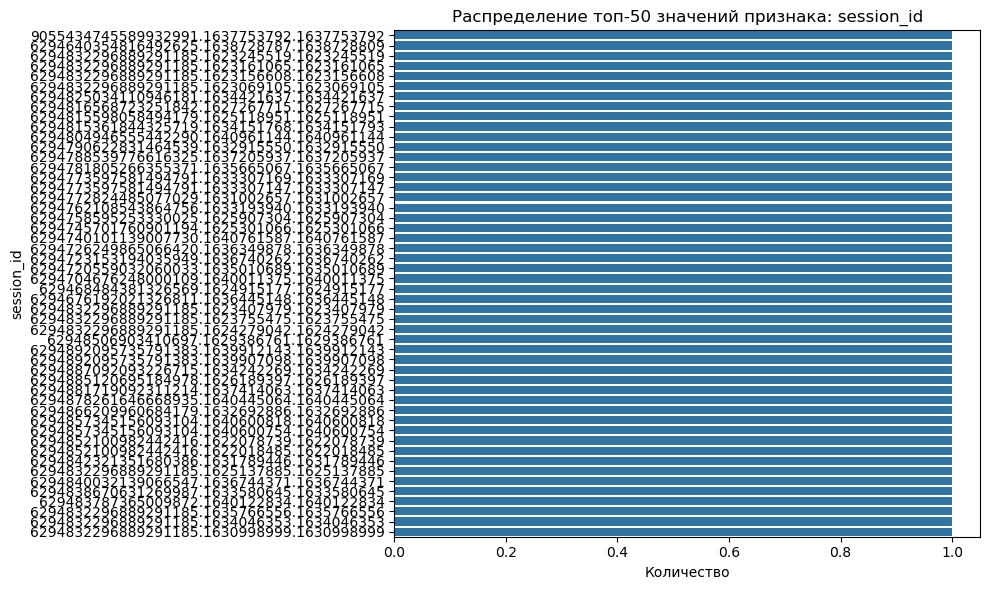

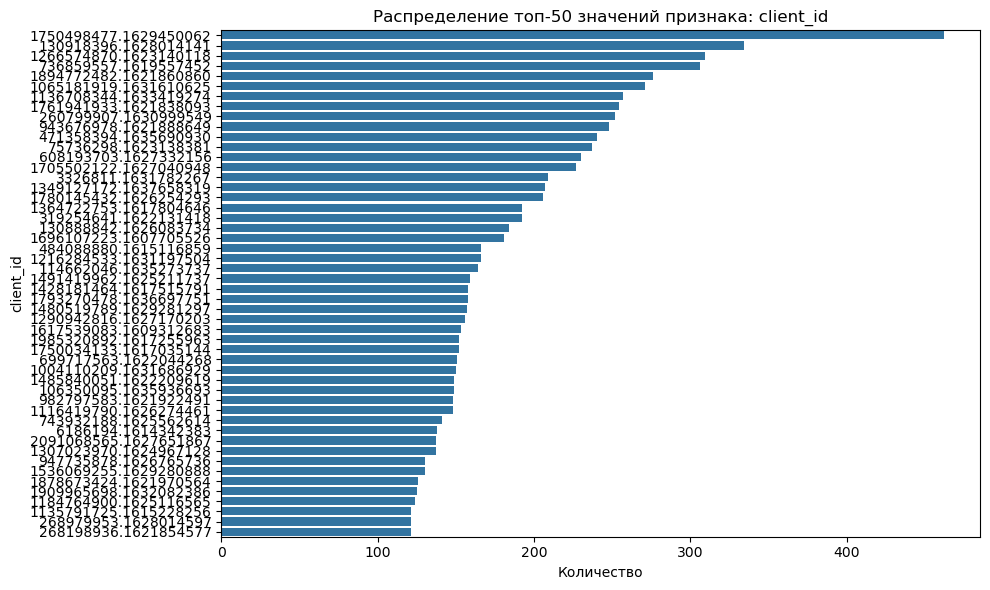

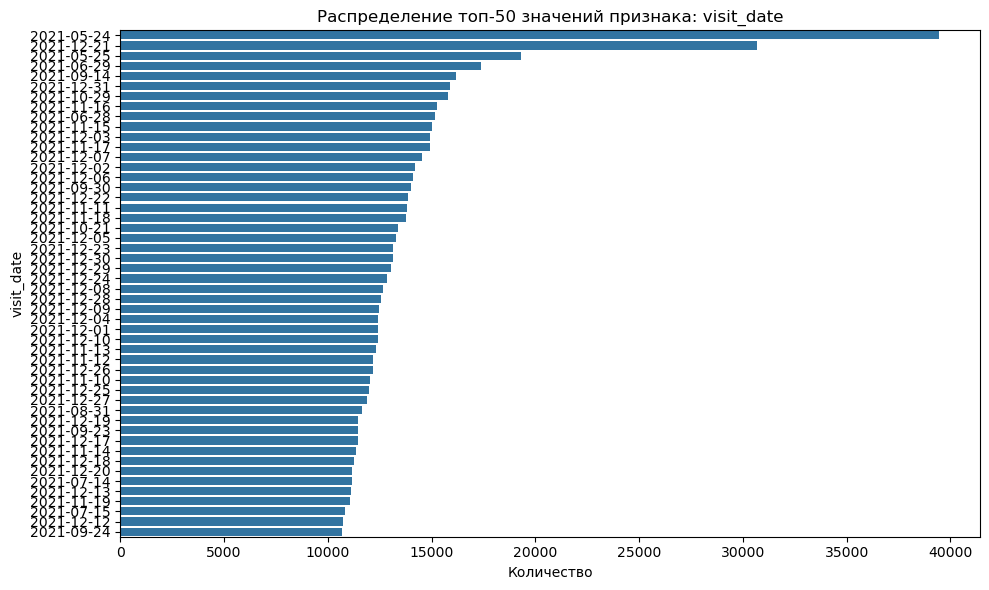

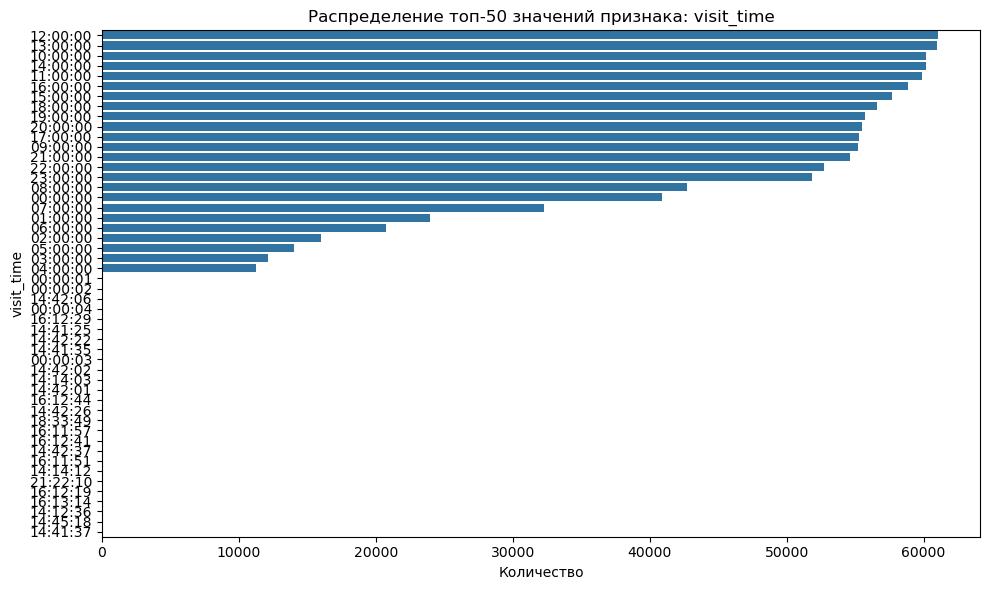

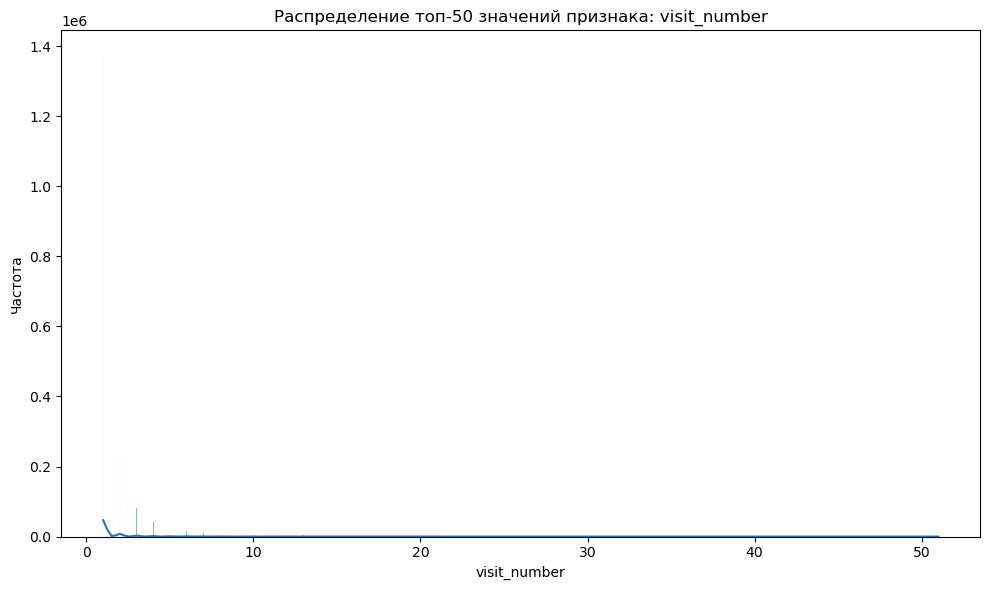

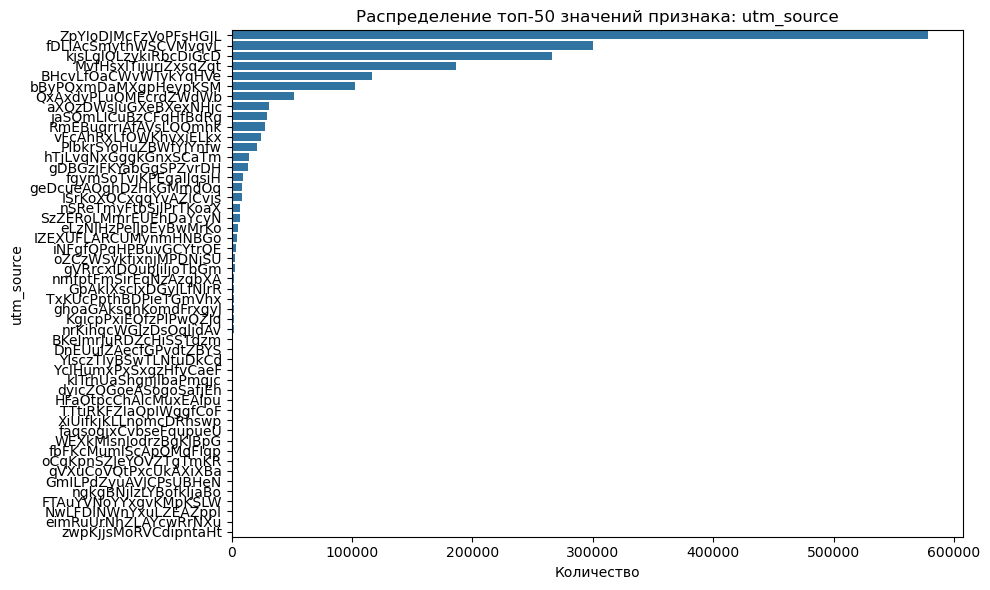

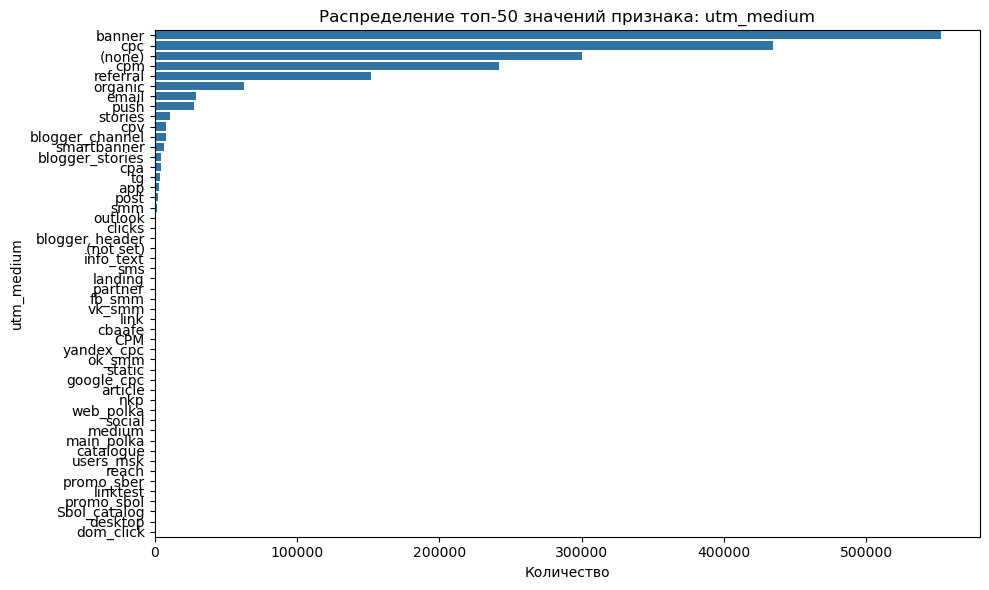

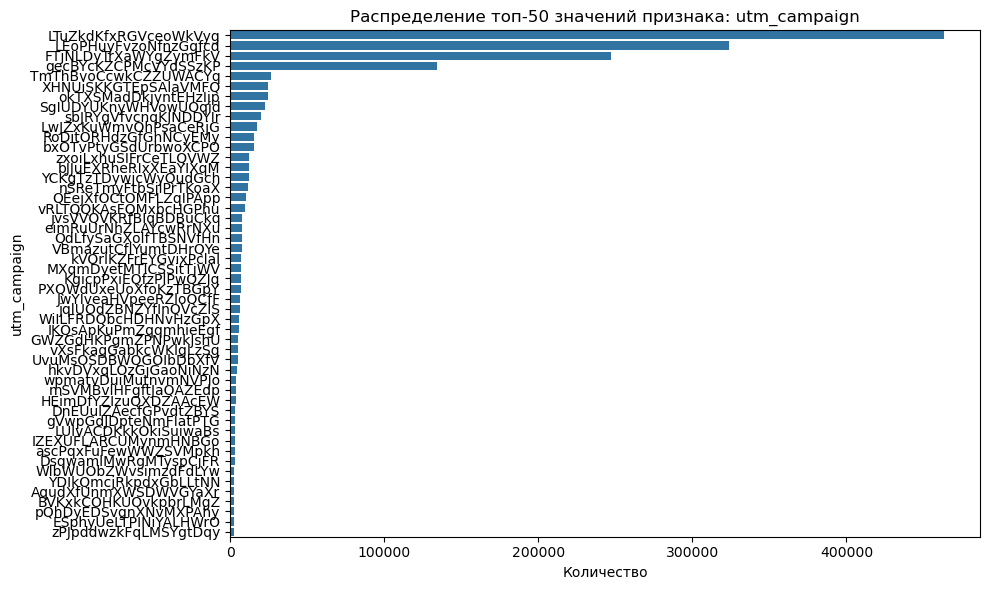

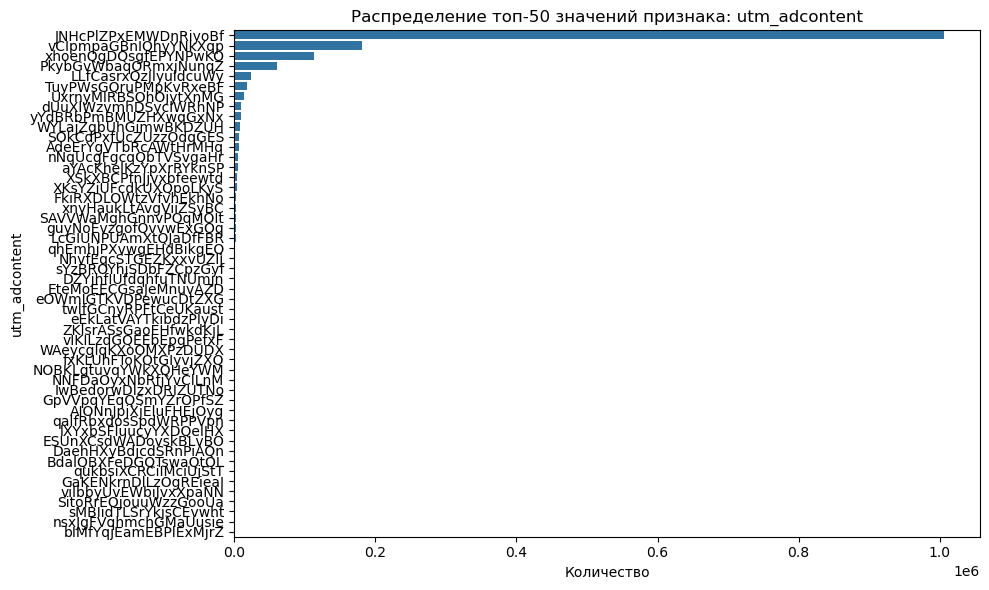

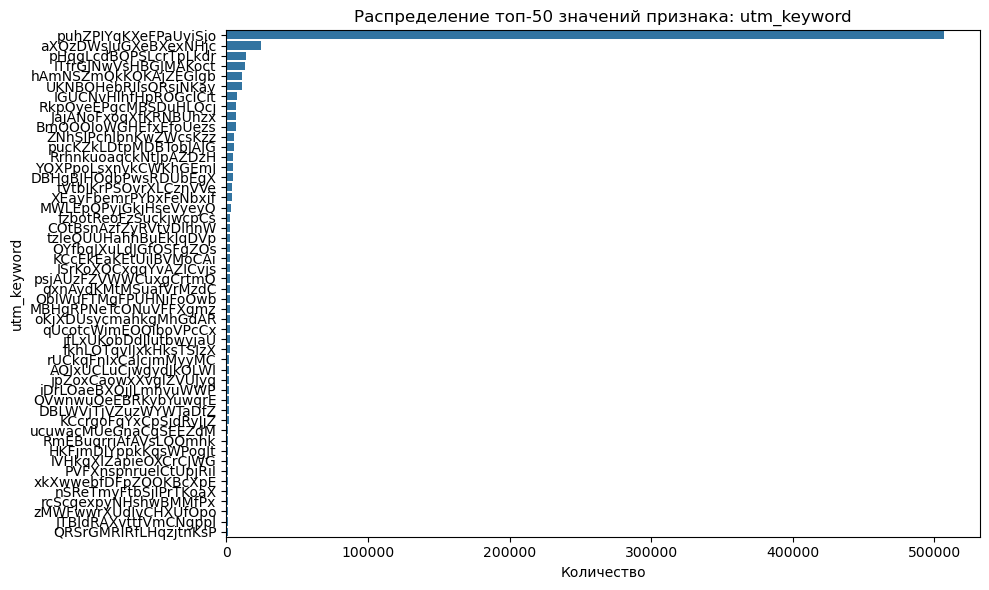

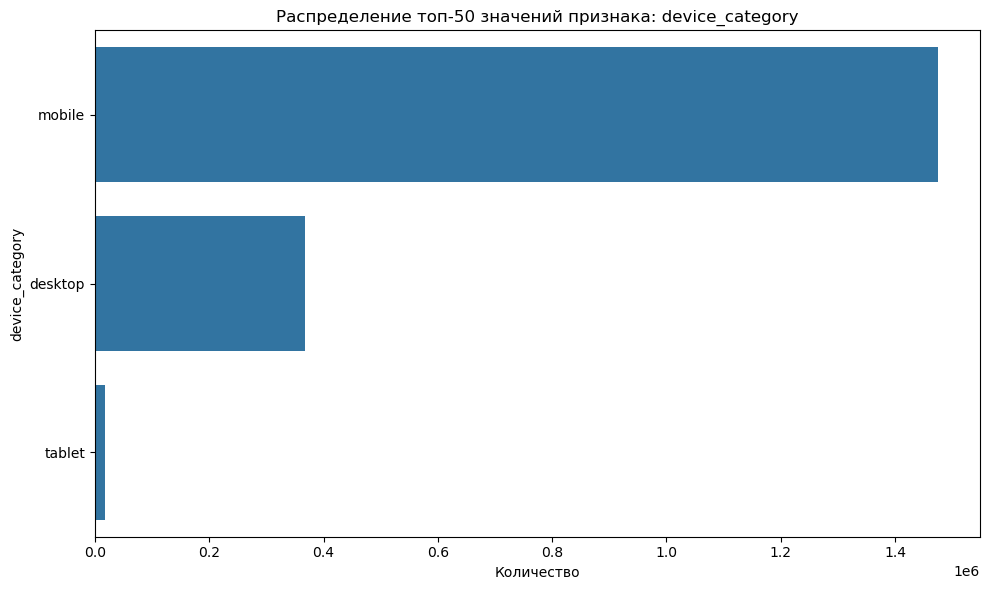

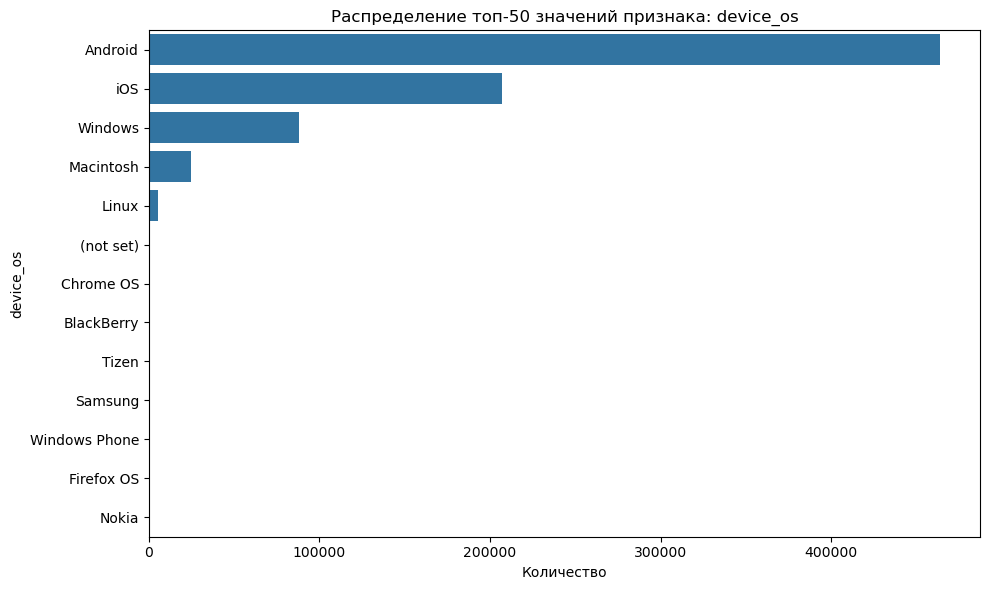

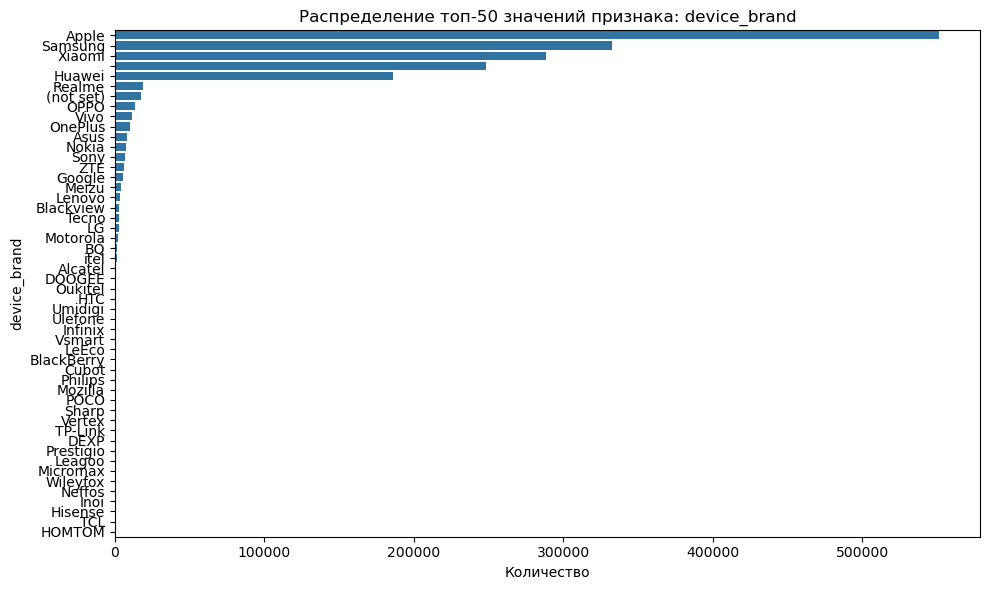

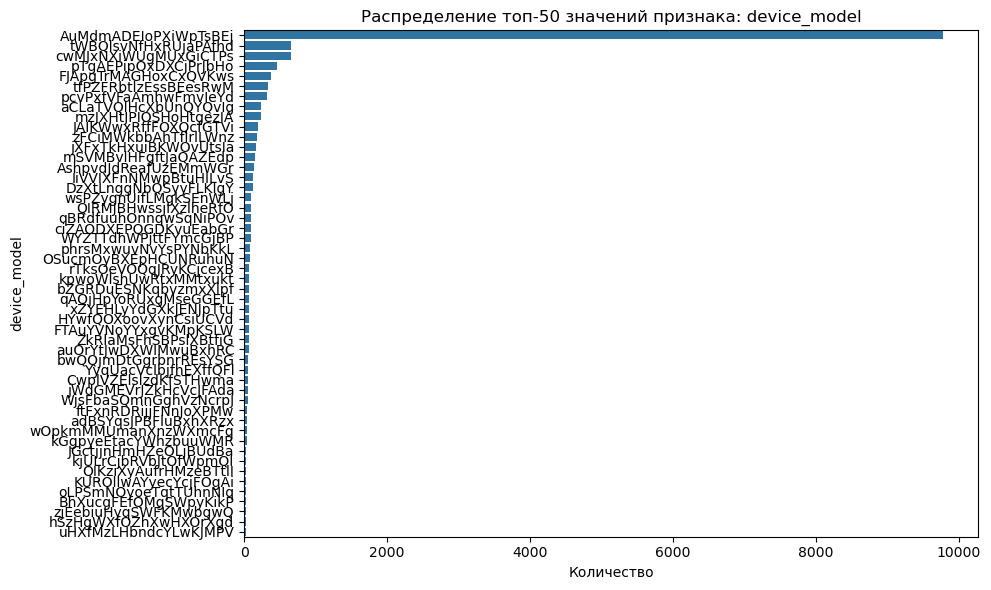

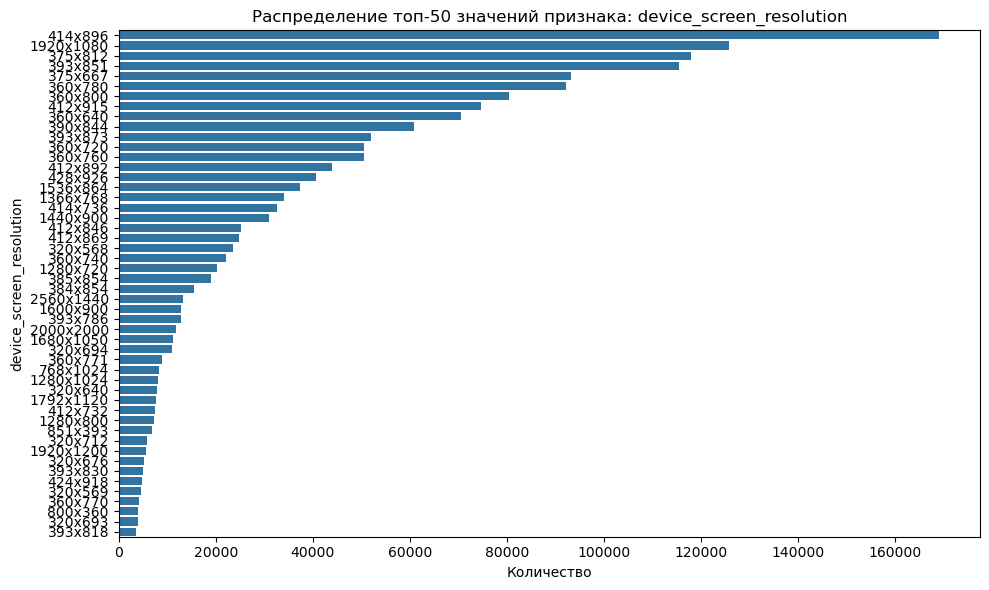

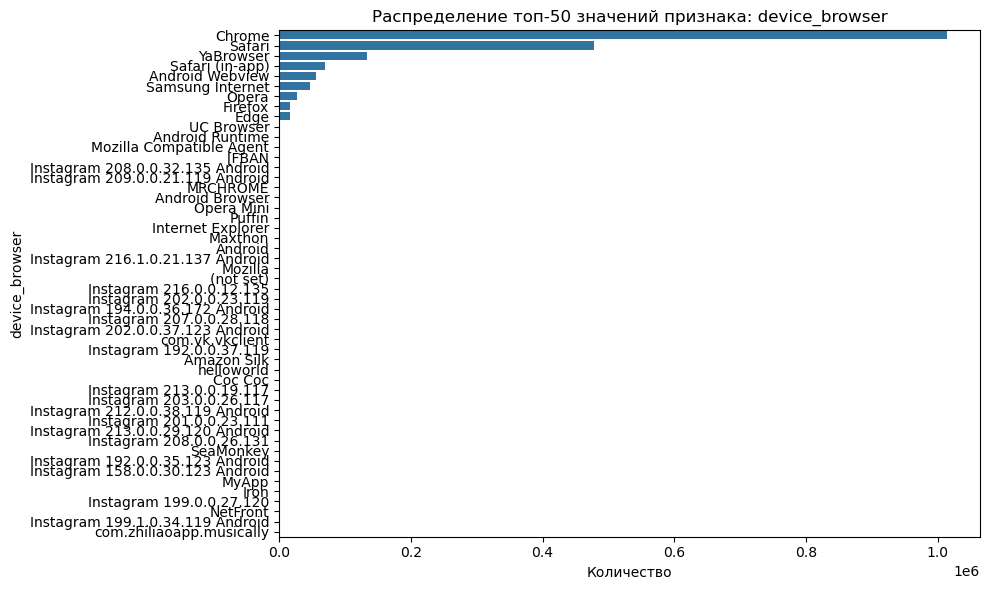

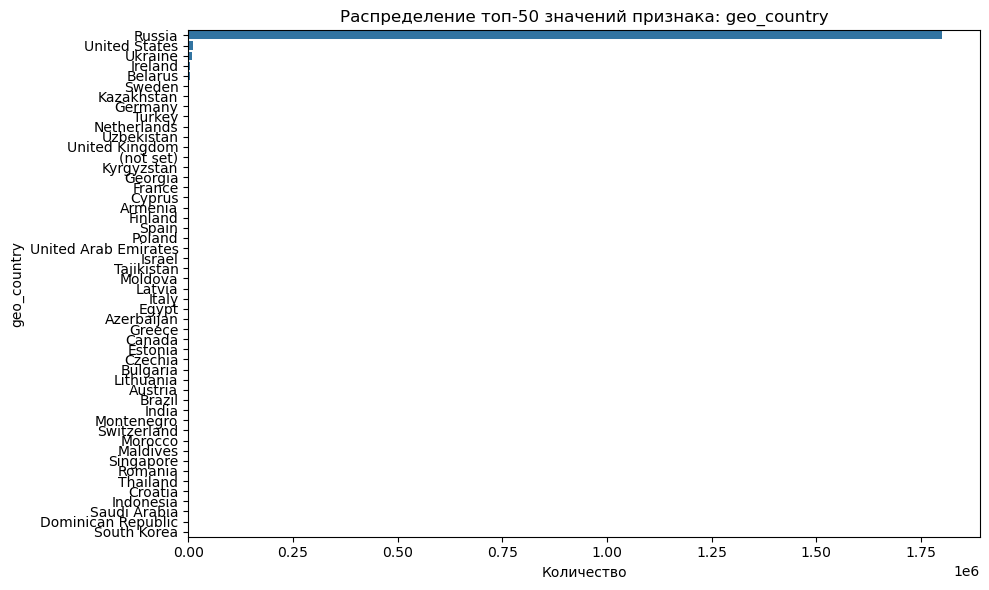

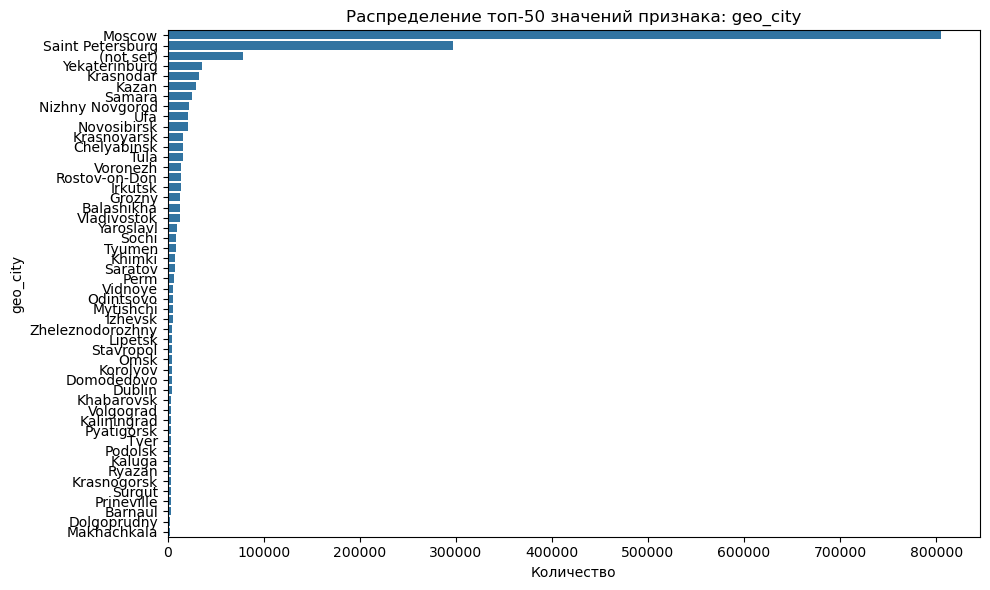

In [17]:
vizual_dataframe_columns(ga_sessions)

#### 1. **Общая информация о датасете**
- **Размер данных**:  
  - Количество строк: 1 860 042  
  - Количество столбцов: 18  
- **Типы данных**:  
  - Числовые (`int64`): `visit_number` (1 столбец)  
  - Категориальные (`object`): остальные 17 столбцов  

- **Столбцы с пропусками**: 
 
| Столбец             | Количество пропусков | Доля пропусков (%) |  
|---------------------|----------------------|--------------------|  
| utm_source          | 97                   | ~0.005%            |  
| utm_campaign        | 219 603              | ~11.8%             |  
| utm_adcontent       | 335 615              | ~18.0%             |  
| utm_keyword         | 1 082 061            | ~58.2%             |  
| device_os           | 1 070 138            | ~57.5%             |  
| device_brand        | 367 178              | ~19.7%             |  
| device_model        | 1 843 704            | ~99.1%             |  

#### 3. **Анализ столбца `visit_number`**
- 75% пользователей имеют ≤2 визитов (медиана = 1).  
- Максимальное значение (564) — аномалия (возможно, бот или технический артефакт).  

#### 4. **Первичные наблюдения**
- **Проблемные поля**:  
- `device_model` и `utm_keyword` содержат >50% пропусков — возможно, исключить из анализа.  
- `utm_campaign` и `utm_adcontent` имеют значительные пропуски (~12-18%) — нужна стратегия заполнения.  
- **Геоданные и устройства**:  
- Полно заполнены `geo_country`, `geo_city`, `device_category` — полезны для сегментации.  
- `device_os` и `device_brand` требуют обработки пропусков.  
- **Временные данные**:  
- `visit_date` и `visit_time` без пропусков — можно анализировать активность по времени.  

Рассмотрим уникальные значения столбцов

#### 1. **Идентификаторы**
- **`session_id`**:
  - Уникальных значений: 1,860,042 (полное соответствие количеству строк)
  - Все значения встречаются ровно 1 раз → уникальный идентификатор

- **`client_id`**:
  - Уникальных значений: 1,391,717 (~75% от общего числа строк)
  - Топ-1 клиент: повторяется 462 раза → есть пользователи с множественными сессиями

#### 2. **Временные метки**
- **`visit_date`**:
  - Уникальных дат: 226 (охватывают ~7.5 месяцев)
  - Пиковые даты: 
    - 2021-05-24 (39,453 сессии)
    - 2021-12-21 (30,704 сессии)

- **`visit_time`**:
  - Уникальных значений: 85,318 (точность до секунды)
  - Аномалия: 12:00:00 встречается 61,067 раз → возможны технические артефакты

#### 3. **UTM-метки**
| Параметр       | Уникальных | Топ-1 значение (доля)         | Пропуски |
|----------------|------------|-------------------------------|----------|
| `utm_source`   | 293        | ZpYIoDJMc... (31.1%)          | 97       |
| `utm_medium`   | 56         | banner (29.7%)                | 0        |
| `utm_campaign` | 412        | LTuZkdKfx... (24.9%)          | 219,603  |
| `utm_adcontent`| 286        | JNHcPlZPx... (54.1%)          | 335,615  |
| `utm_keyword`  | 1,219      | puhZPIYqK... (27.2%)          | 1,082,061|

**Наблюдения**:
- Высокая энтропия значений (хеш-подобные строки)
- `utm_adcontent` имеет доминирующее значение (54%)

#### 4. **Устройства**
- **`device_category`**:
  - Распределение: mobile (79.3%), desktop (19.7%), tablet (1%)

- **`device_os`**:
  - Топ-3: Android (24.9%), iOS (11.1%), Windows (4.7%)
  - 57.5% пропусков → требует обработки

- **`device_brand`**:
  - Лидеры: Apple (29.6%), Samsung (17.9%), Xiaomi (15.5%)
  - 205 уникальных брендов

- **`device_model`**:
  - 99.1% пропусков → малопригоден для анализа

- **`device_screen_resolution`**:
  - Популярные разрешения: 414x896 (9.1%), 1920x1080 (6.8%)

#### 5. **Геоданные**
- **`geo_country`**:
  - Россия: 96.8% трафика
  - США: 0.63% (второе место)

- **`geo_city`**:
  - Москва: 43.3% сессий
  - СПб: 16% 
  - 4.2% пропусков → требует обработки

#### 6. **Браузеры**
- **`device_browser`**:
  - Chrome: 54.5%
  - Safari: 25.7%
  - Я.Браузер: 7.2%

#### Критические выводы:
1. **Проблемные поля**:
   - `device_model` и `utm_keyword` практически бесполезны из-за пропусков
   - `utm_adcontent` требует проверки на корректность (54% одно значение)

2. **География**:
   - Сильная концентрация трафика в России (Москва + СПб = 59.3%)

3. **Временные аномалии**:
   - Пики в мае и декабре 2021
   - Подозрительная активность в 12:00:00

#### Анализ датасета действий пользователей

In [22]:
inform(ga_hits)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.3+ GB


Первые несколько строк датасета:


session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/cars?utm_source_initial=yandex&ut...           quiz   
4  sberauto.com/cars/all/mercedes-benz/cla-klasse...           quiz   

  event_action event_label event_value  
0    quiz_show         NaN        None  
1    quiz_show         NaN        None  
2    quiz_show         NaN        None  
3    quiz_show         NaN        None  
4    quiz_show         NaN        None



Описательная статистика:


hit_time    hit_number
count  6.566148e+06  1.572647e+07
mean   2.091050e+05  2.356715e+01
std    4.032110e+05  2.887713e+01
min    0.000000e+00  1.000000e+00
25%    2.412000e+04  7.000000e+00
50%    8.994100e+04  1.500000e+01
75%    2.195352e+05  2.900000e+01
max    1.315688e+07  5.000000e+02



Количество пропусков
session_id: 0
hit_date: 0
hit_time: 9160322
hit_number: 0
hit_type: 0
hit_referer: 6274804
hit_page_path: 0
event_category: 0
event_action: 0
event_label: 3760184
event_value: 15726470




'Количествово дубликатов:0'



Количество уникальных значений
session_id: 1734610
hit_date: 226
hit_time: 925887
hit_number: 500
hit_type: 1
hit_referer: 37873
hit_page_path: 342715
event_category: 52
event_action: 230
event_label: 39825
event_value: 0


In [23]:
analyze_dataframe_columns(ga_hits)


--- Столбец: session_id ---
----------------------------------------
Количество уникальных значений: 1734610
Первые 5 значений:
['5639623078712724064.1640254056.1640254056', '7750352294969115059.1640271109.1640271109', '885342191847998240.1640235807.1640235807', '142526202120934167.1640211014.1640211014', '3450086108837475701.1640265078.1640265078']

Топ-5 наиболее частых значений:
session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
Name: count, dtype: int64

Топ-5 наиболее редких значений:
session_id
4570994095441102117.1630324006.1630324006    1
768506153535315810.1630314342.1630314342     1
5517253735248338264.1630315080.1630315080    1
4054272189286640867.1630334209.1630334209    1
5381267721977892188.1640271196.1640271196    1
Name: count, dtype: int64

Количество пропусков: 0
Пр

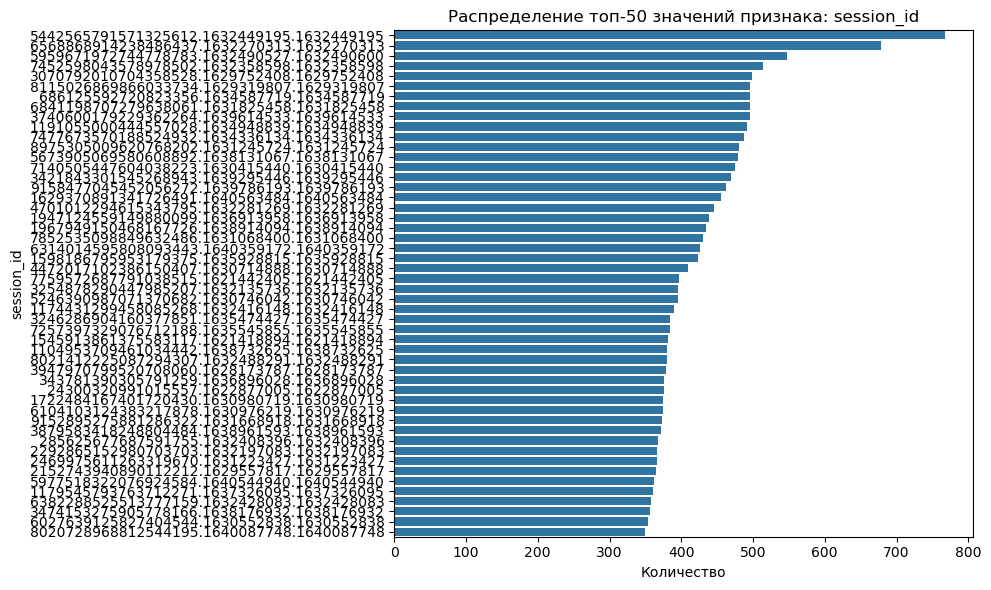

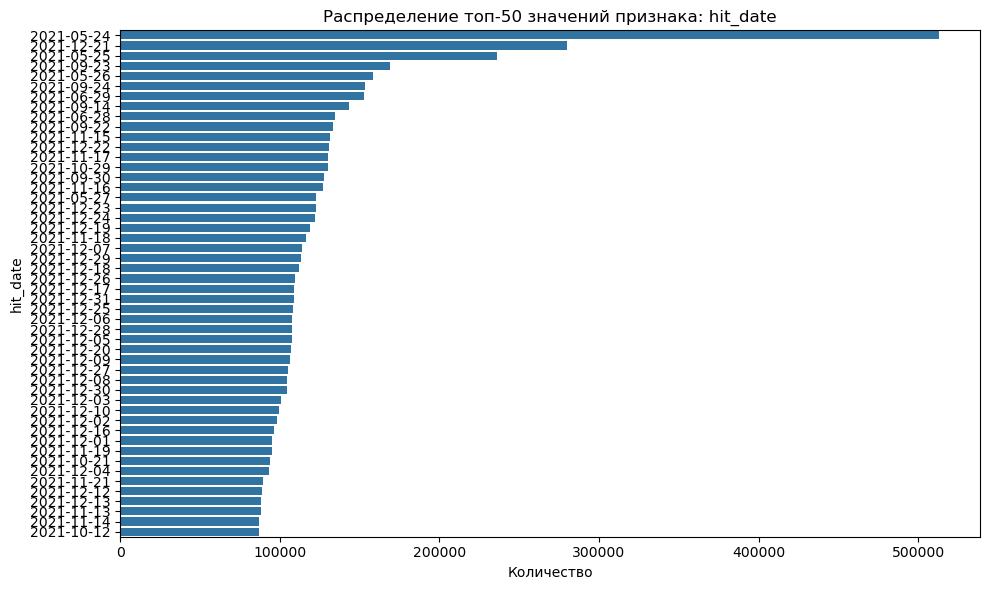

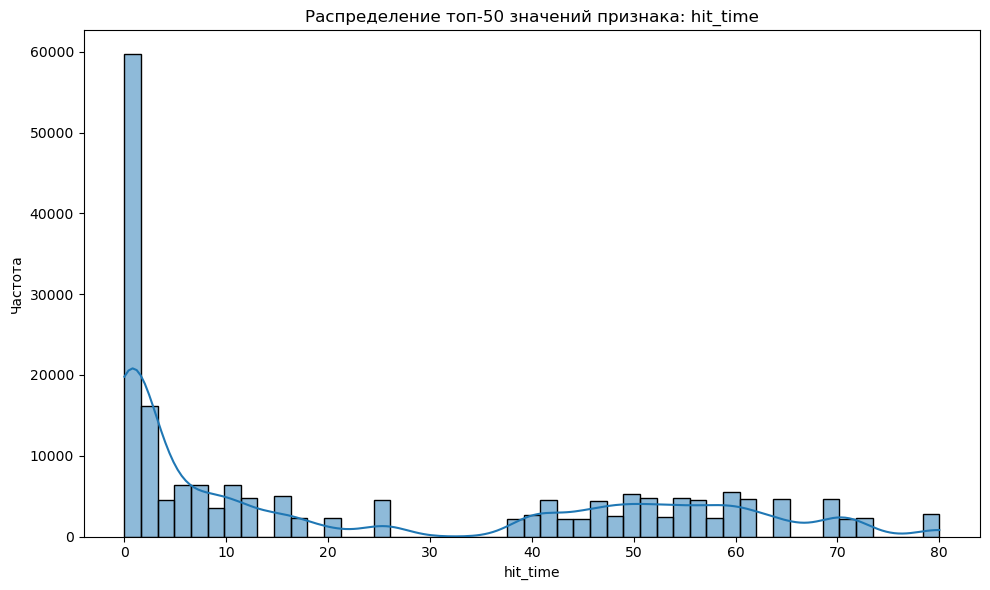

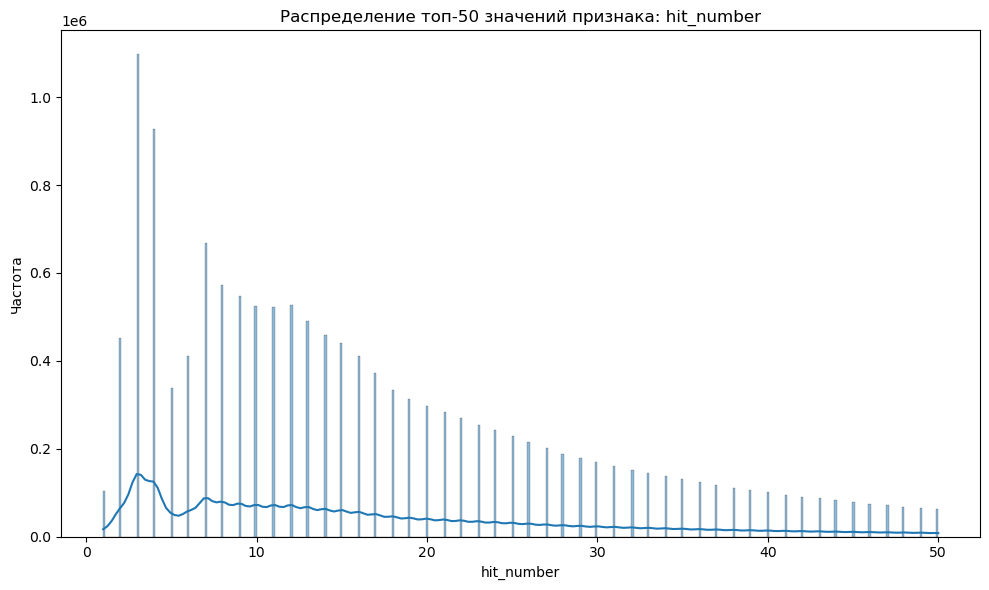

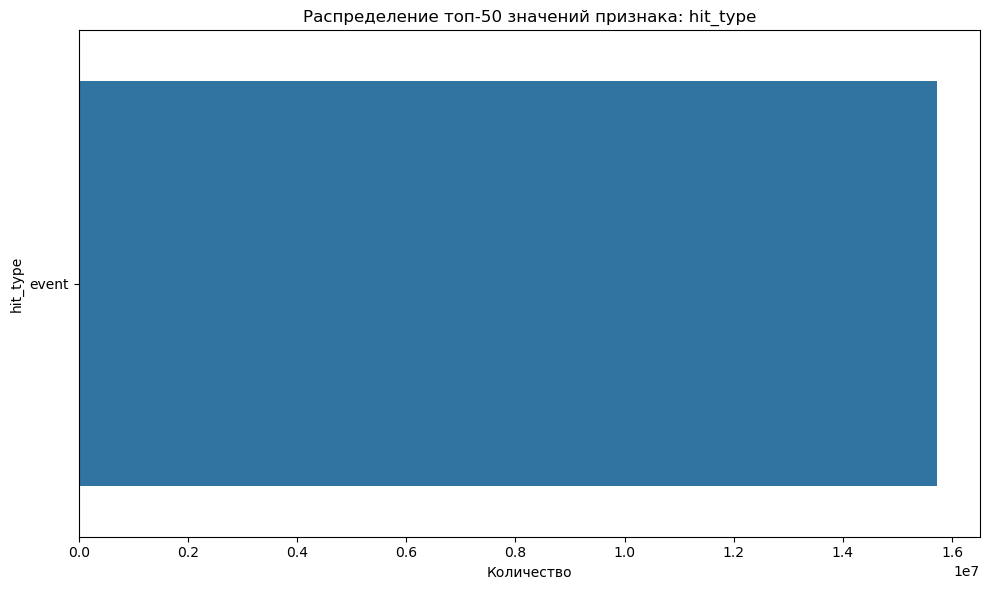

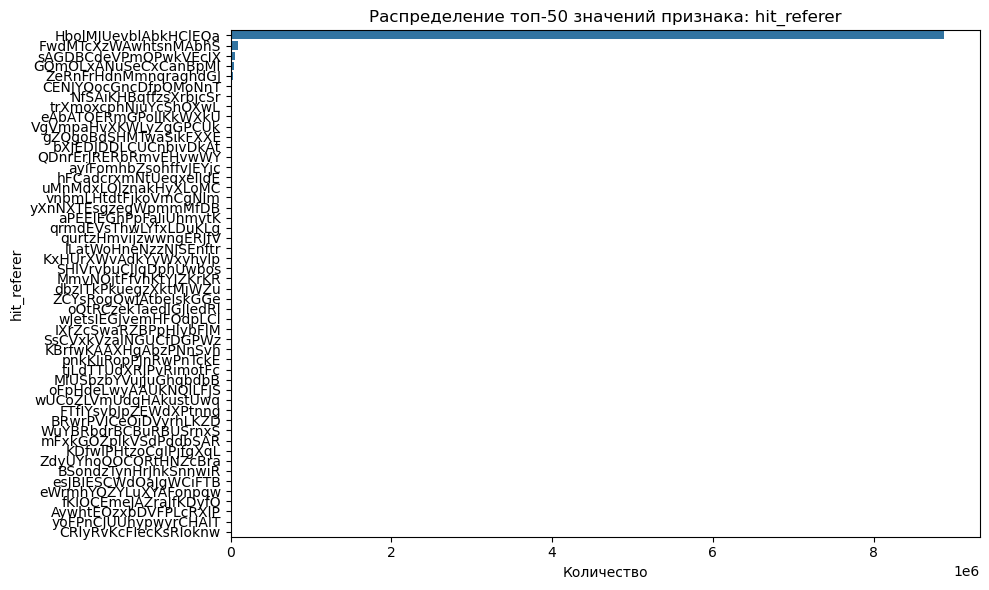

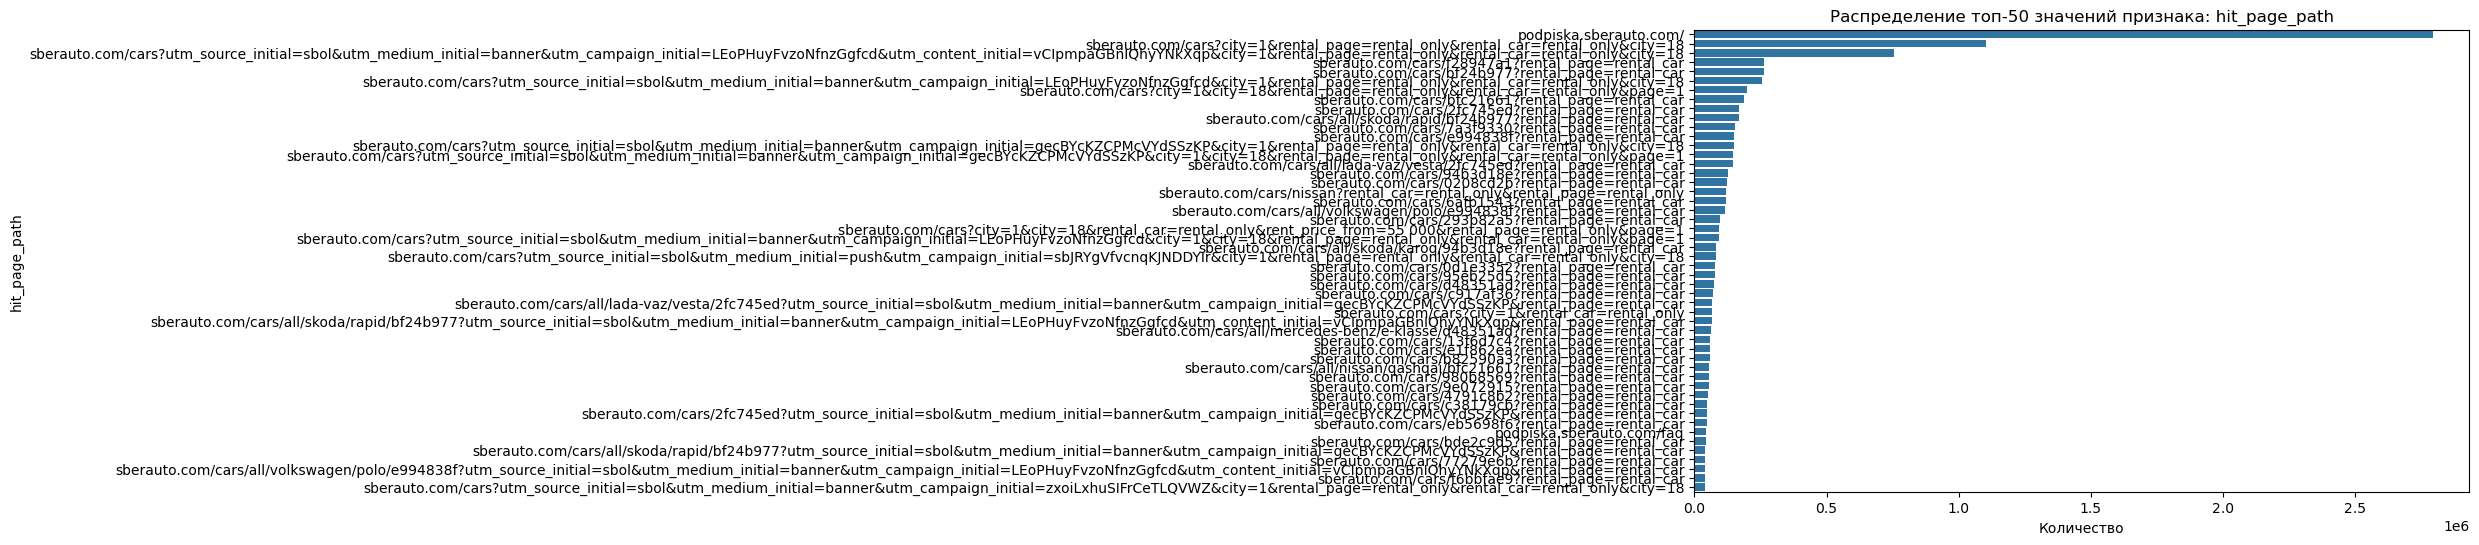

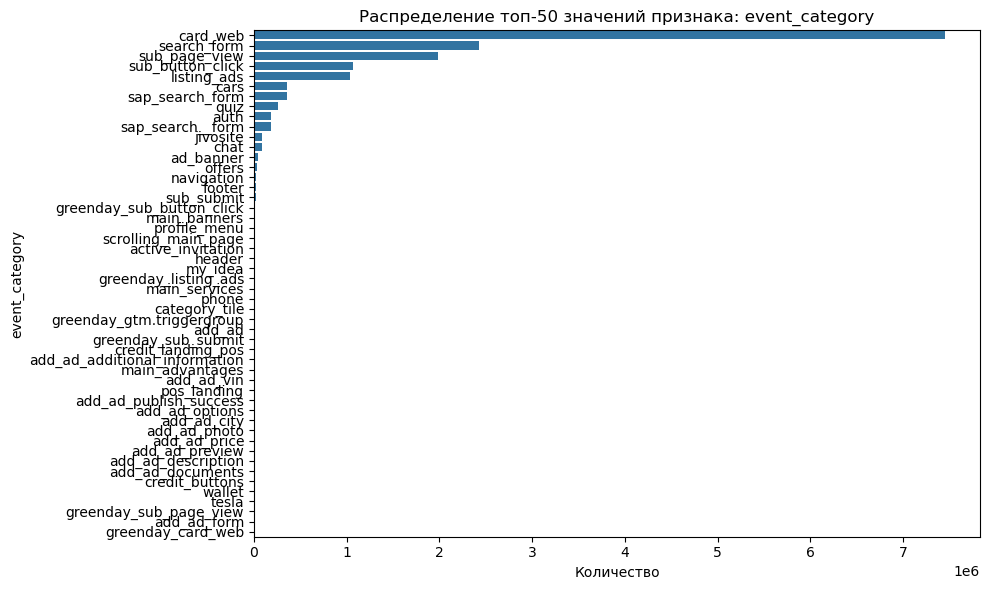

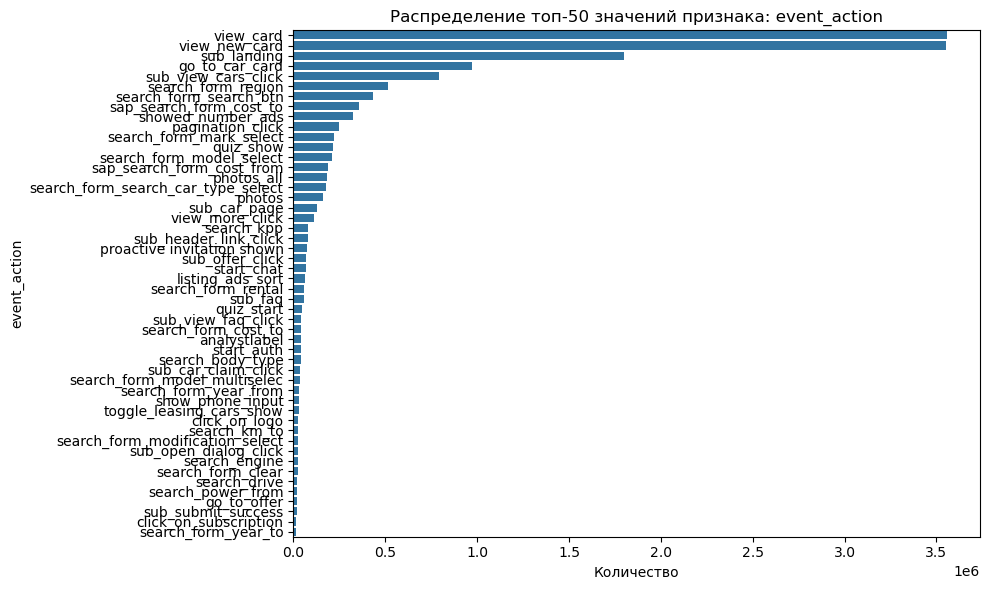

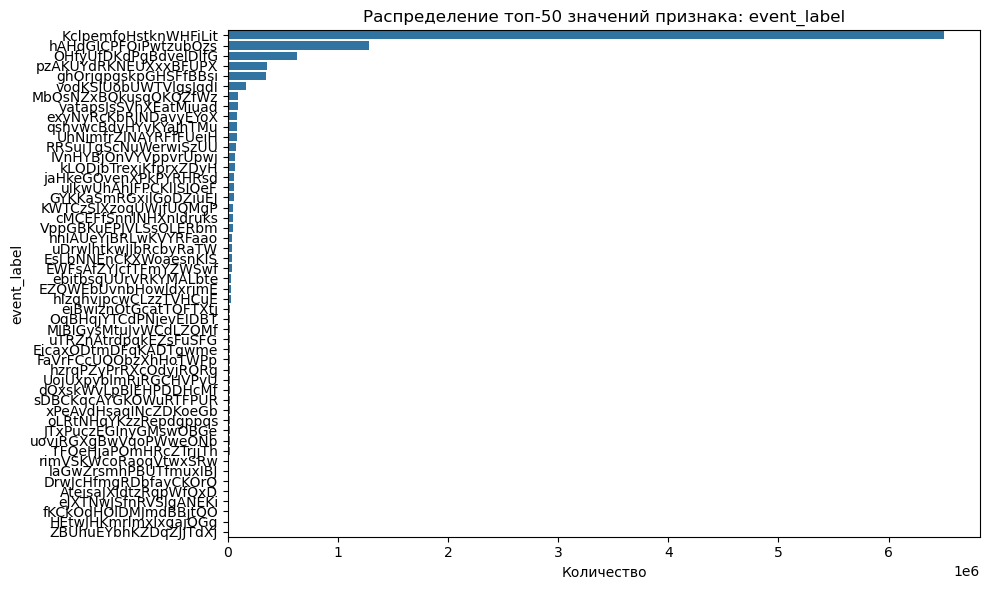

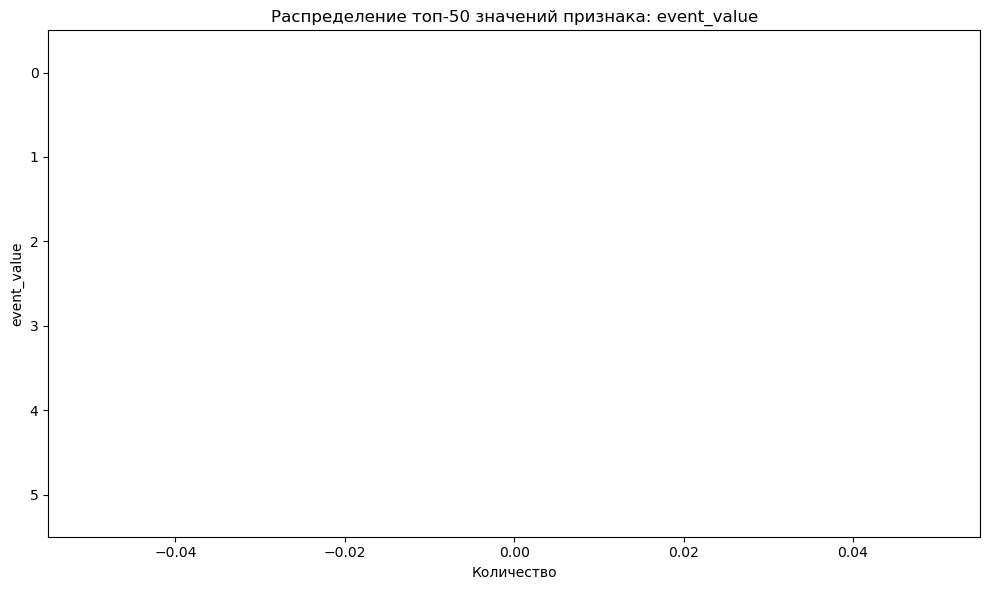

In [24]:
vizual_dataframe_columns(ga_hits)

### Анализ датасета `ga_hits`

#### 1. **Общая информация**
- **Объем данных**: 15,726,470 строк, 11 столбцов
- **Типы данных**:
  - Числовые: `hit_time` (float), `hit_number` (int), `event_value` (float)
  - Категориальные: остальные 8 столбцов (object)

#### 2. **Пропуски в данных**
| Столбец         | Пропуски | Доля пропусков |
|-----------------|----------|----------------|
| `hit_time`      | 9,160,322 | 58.25%         |
| `hit_referer`   | 6,274,804 | 39.90%         |
| `event_label`   | 3,760,184 | 23.91%         |
| `event_value`   | 15,726,470| 100%           |

**Критические наблюдения**:
- `event_value` полностью пустой - рекомендуется исключить из анализа
- `hit_time` отсутствует в 58% записей

#### 3. **Распределение числовых данных**
- **`hit_number`** (номер хита в сессии):
  - Среднее: 23.57
  - Медиана: 15
  - Максимум: 500 (возможны аномалии)
  
- **`hit_time`** (временная метка):
  - Сильный разброс: от 0 до 13,156,880 (в миллисекундах)
  - 75% значений < 219,535

#### 4. **Анализ категориальных полей**
- **`hit_type`**:
  - Только 1 уникальное значение ("event") - бесполезен для анализа
- **`hit_page_path`**:
  - 342,715 уникальных URL (высокая вариативность)
- **`event_category`**:
  - 52 уникальных категории событий
- **`event_action`**:
  - 230 уникальных действий

#### 5. **Временные данные**
- **`hit_date`**:
  - 226 уникальных дат (совпадает с `ga_sessions`)
  - Аналогичное распределение по датам

#### 6. **Связь с ga_sessions**
- **`session_id`**:
  - Уникальных: 1,734,610 (меньше чем в `ga_sessions`)
  - Среднее ~9 хитов на сессию

#### 7. **Ключевые проблемы**
1. **Технические аномалии**:
   - 100% пропусков в `event_value`
   - 58% пропусков в `hit_time`
   - Все записи одного типа (`hit_type="event"`)

### далее займемся пердобработкой данных смотри файл (Data Preprocessing)